# Read raw data of T2,T2F,TR and T3 -> smooth

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Smooth data

In [8]:
#Smooth data from raw files
# we can only smooth data for parameters where we have more than one value and it varies drastically across
# a) multiple tries on the same run (this happens only with T2F and TR as they are in a loop the robot can retry multiple times)
# b) multiple runs
#where a run is the robot moving from s0 to an end state

#
def get_full_path(folder_path, filename):
    return os.path.join(folder_path, filename)

def clean_file(output_file):
    with open(output_file, "w") as output_file:
        pass
    
def winsorize(df,n_std=2,ignore=-1): #n_std: -1= mean, 1,2,3=standar deviations
    # Step 1: Ignore values that are -1
    filtered_df = df[df != -1]
    
    # Step 2: Calculate mean and standard deviation of the remaining values
    mean = filtered_df.stack().mean()
    std_dev = filtered_df.stack().std()
    
    # Step 3: Replace values outside 2 standard deviations with the mean +- n standard deviations
    df2 = df.copy()
    for index, row in df2.iterrows():
        for column, value in row.iteritems():
            if value!=-1:
                
                if(n_std<0):
                    if value> (mean + n_std*-1 * std_dev):
                        df2.loc[index, column] = mean
                    elif value< (mean - n_std*-1 * std_dev):
                        df2.loc[index, column] = mean
                else:
                    if value> (mean + n_std * std_dev):
                        df2.loc[index, column] = mean + n_std * std_dev
                    elif value< (mean - n_std * std_dev):
                        df2.loc[index, column] = mean - n_std * std_dev
    return df2


#outside n standar deviations smooth value by change it to mean +- n*std


def get_smooth(full_path,full_path_output,col="T2,T2F,TR,T3",n_std=2,verbose="true"):
    df = pd.read_csv(full_path)
    dforiginal = df.copy()
    
    col = col.split(",")
    
    for c in col:
        #1 get only columns matching name
        if c=="T2F" or c=="TR": #get all columns
            df_smooth = df.loc[:, df.columns.str.startswith(c)]
        else:
            df_smooth = pd.DataFrame(df[c])
            
        #2 smooth data
        df_smooth = winsorize(df_smooth,n_std,ignore=-1)
    
        #3 replace columns in df with columns from df_smooth if they have the same names
        for column_name in df_smooth.columns:
            df[column_name] = df_smooth[column_name]
        
    #save new df
    df.to_csv(full_path_output, index=False)
    #print one sample
    if "outcome_0.5_0.3_0.5" in full_path_output and verbose=="true":
        print(full_path,dforiginal)
        print(full_path_output,df)
        
        
def smoothRawData(folder_path,col=["T2,T2F,TR,T3"],n_std=2,verbose="true"):
    for filename in os.listdir(folder_path):
        full_path = get_full_path(folder_path, filename)
        if os.path.isfile(full_path) and (filename.split("_")[0]=="outcome"):
            
            full_path_output = get_full_path(folder_path, "smooth"+filename)
            clean_file(full_path_output)

            #print(f"File: {filename}")
            get_smooth(full_path,full_path_output,col,n_std,verbose)
            
    print("New smooth .csv file saved")

### Show smooth data

In [9]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def combineM1M2M3(folder,startwith):#startwith="outcome" or "smoothoutcome"
    files = sorted(os.listdir(folder) )
    # Filter files that start with "outcome/smooth..." and end with ".csv"
    outcome_files = [file for file in files if file.startswith(startwith) and file.endswith(".csv")]
    print(startwith," number of files: ", len(outcome_files))
    # List to hold all DataFrames
    df = []
    for file in outcome_files:
        file_path = os.path.join(folder, file)
        df1 = pd.read_csv(file_path)
        val= file.replace('.csv','').split('outcome_')[1].split('_')
        df1['light']=val[0]
        df1['floor']=val[1]
        df1['obj']=val[2]
        df.append(df1)
    df = pd.concat(df, ignore_index=True)
    print(f"Last data file: {file}")
    return df

def saveDf(df,file):
    df.to_csv(file, index=False) 
    
def printCombinations(df):
    # Loop through every combination of "light", "floor", and "obj"
    count=0
    for light_val in df['light'].unique():
        for floor_val in df['floor'].unique():
            for obj_val in df['obj'].unique():
                count+=1;
    print("Combinations: ",count)


def plotFacetGridBox(df,col):
    if(col=="T2F" or col=="TR"):
        print("Box Plot - Not plot for multicolumns, T2F and TR. Check csv instead.")
        return
    else:
        filtered_df = df[df[col] != -1]
    # Use catplot to create a facet grid of box plots
    g = sns.catplot(x='floor', y=col, col='light', row='obj', kind='box', data=filtered_df, aspect=1.5, height=3)#, showfliers=False with no outliers plot
    # Rotate x-axis labels for better readability
    g.set_xticklabels(rotation=45)
    # Adjust spacing
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Box plots of P1 for each combination of light, floor, and obj')
    plt.show()



New smooth .csv file saved
outcome  number of files:  217
Last data file: outcome_1.0_0.5_1.0.csv


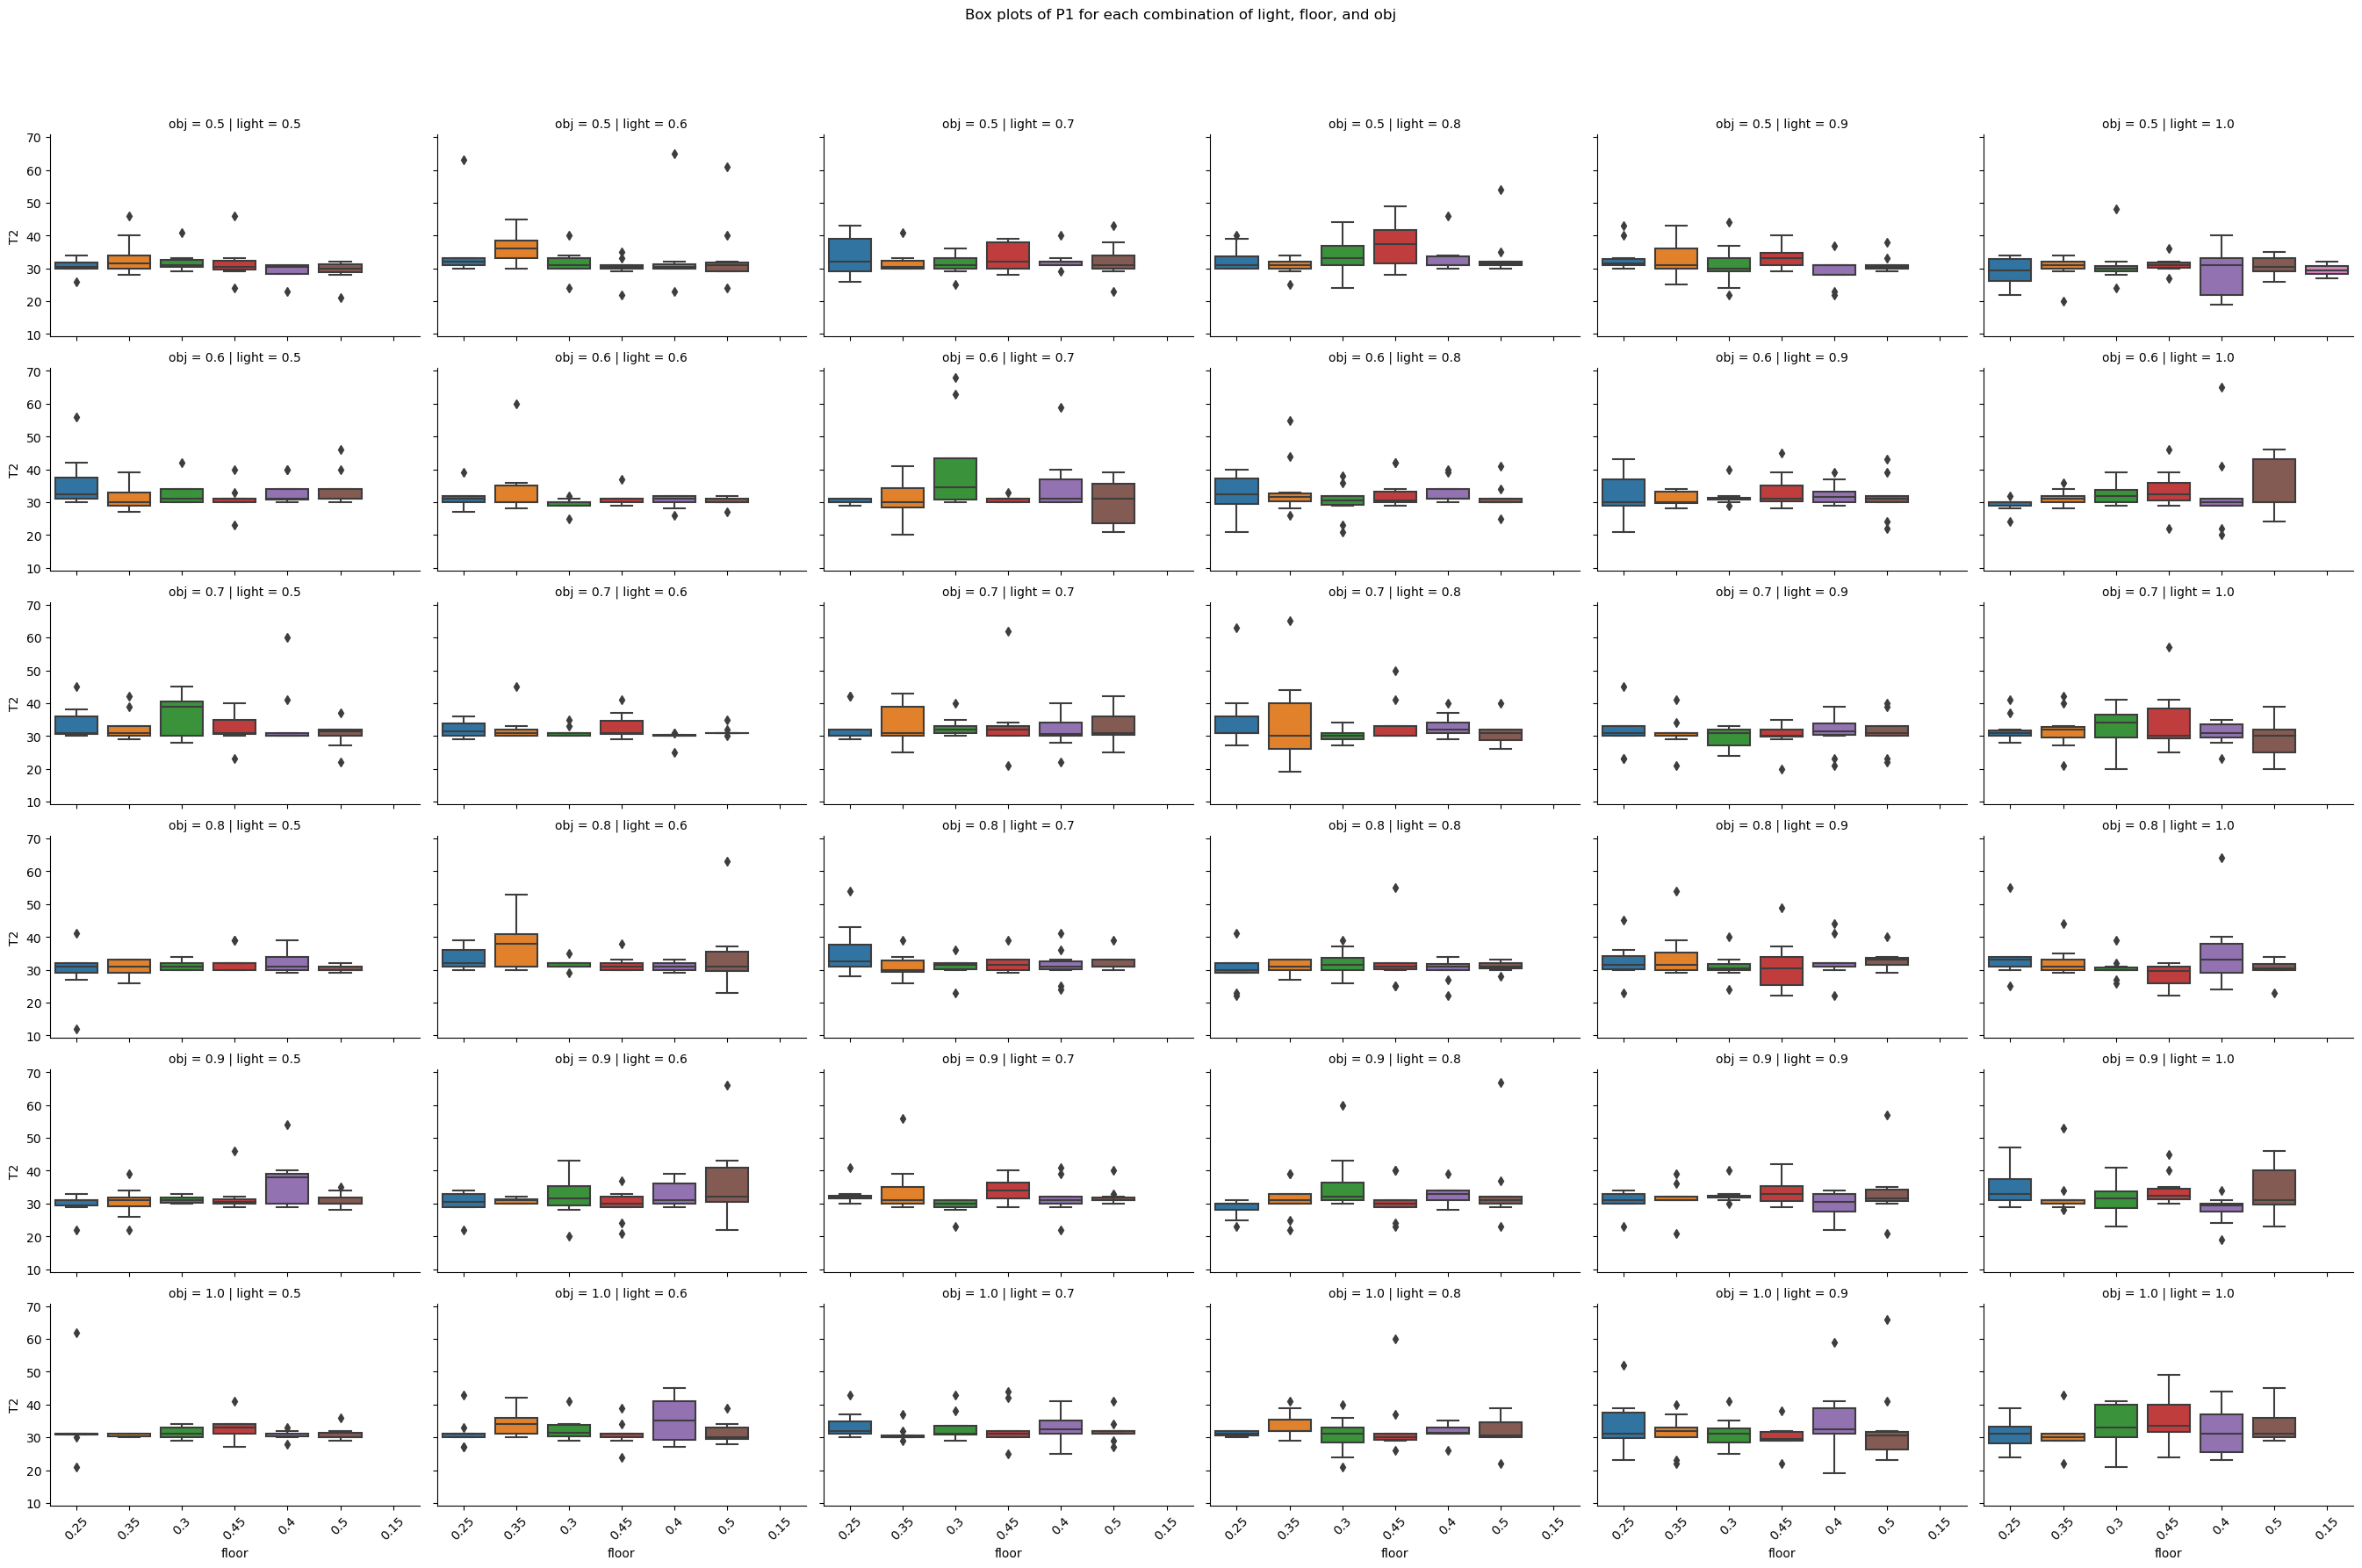

smoothoutcome  number of files:  217
Last data file: smoothoutcome_1.0_0.5_1.0.csv


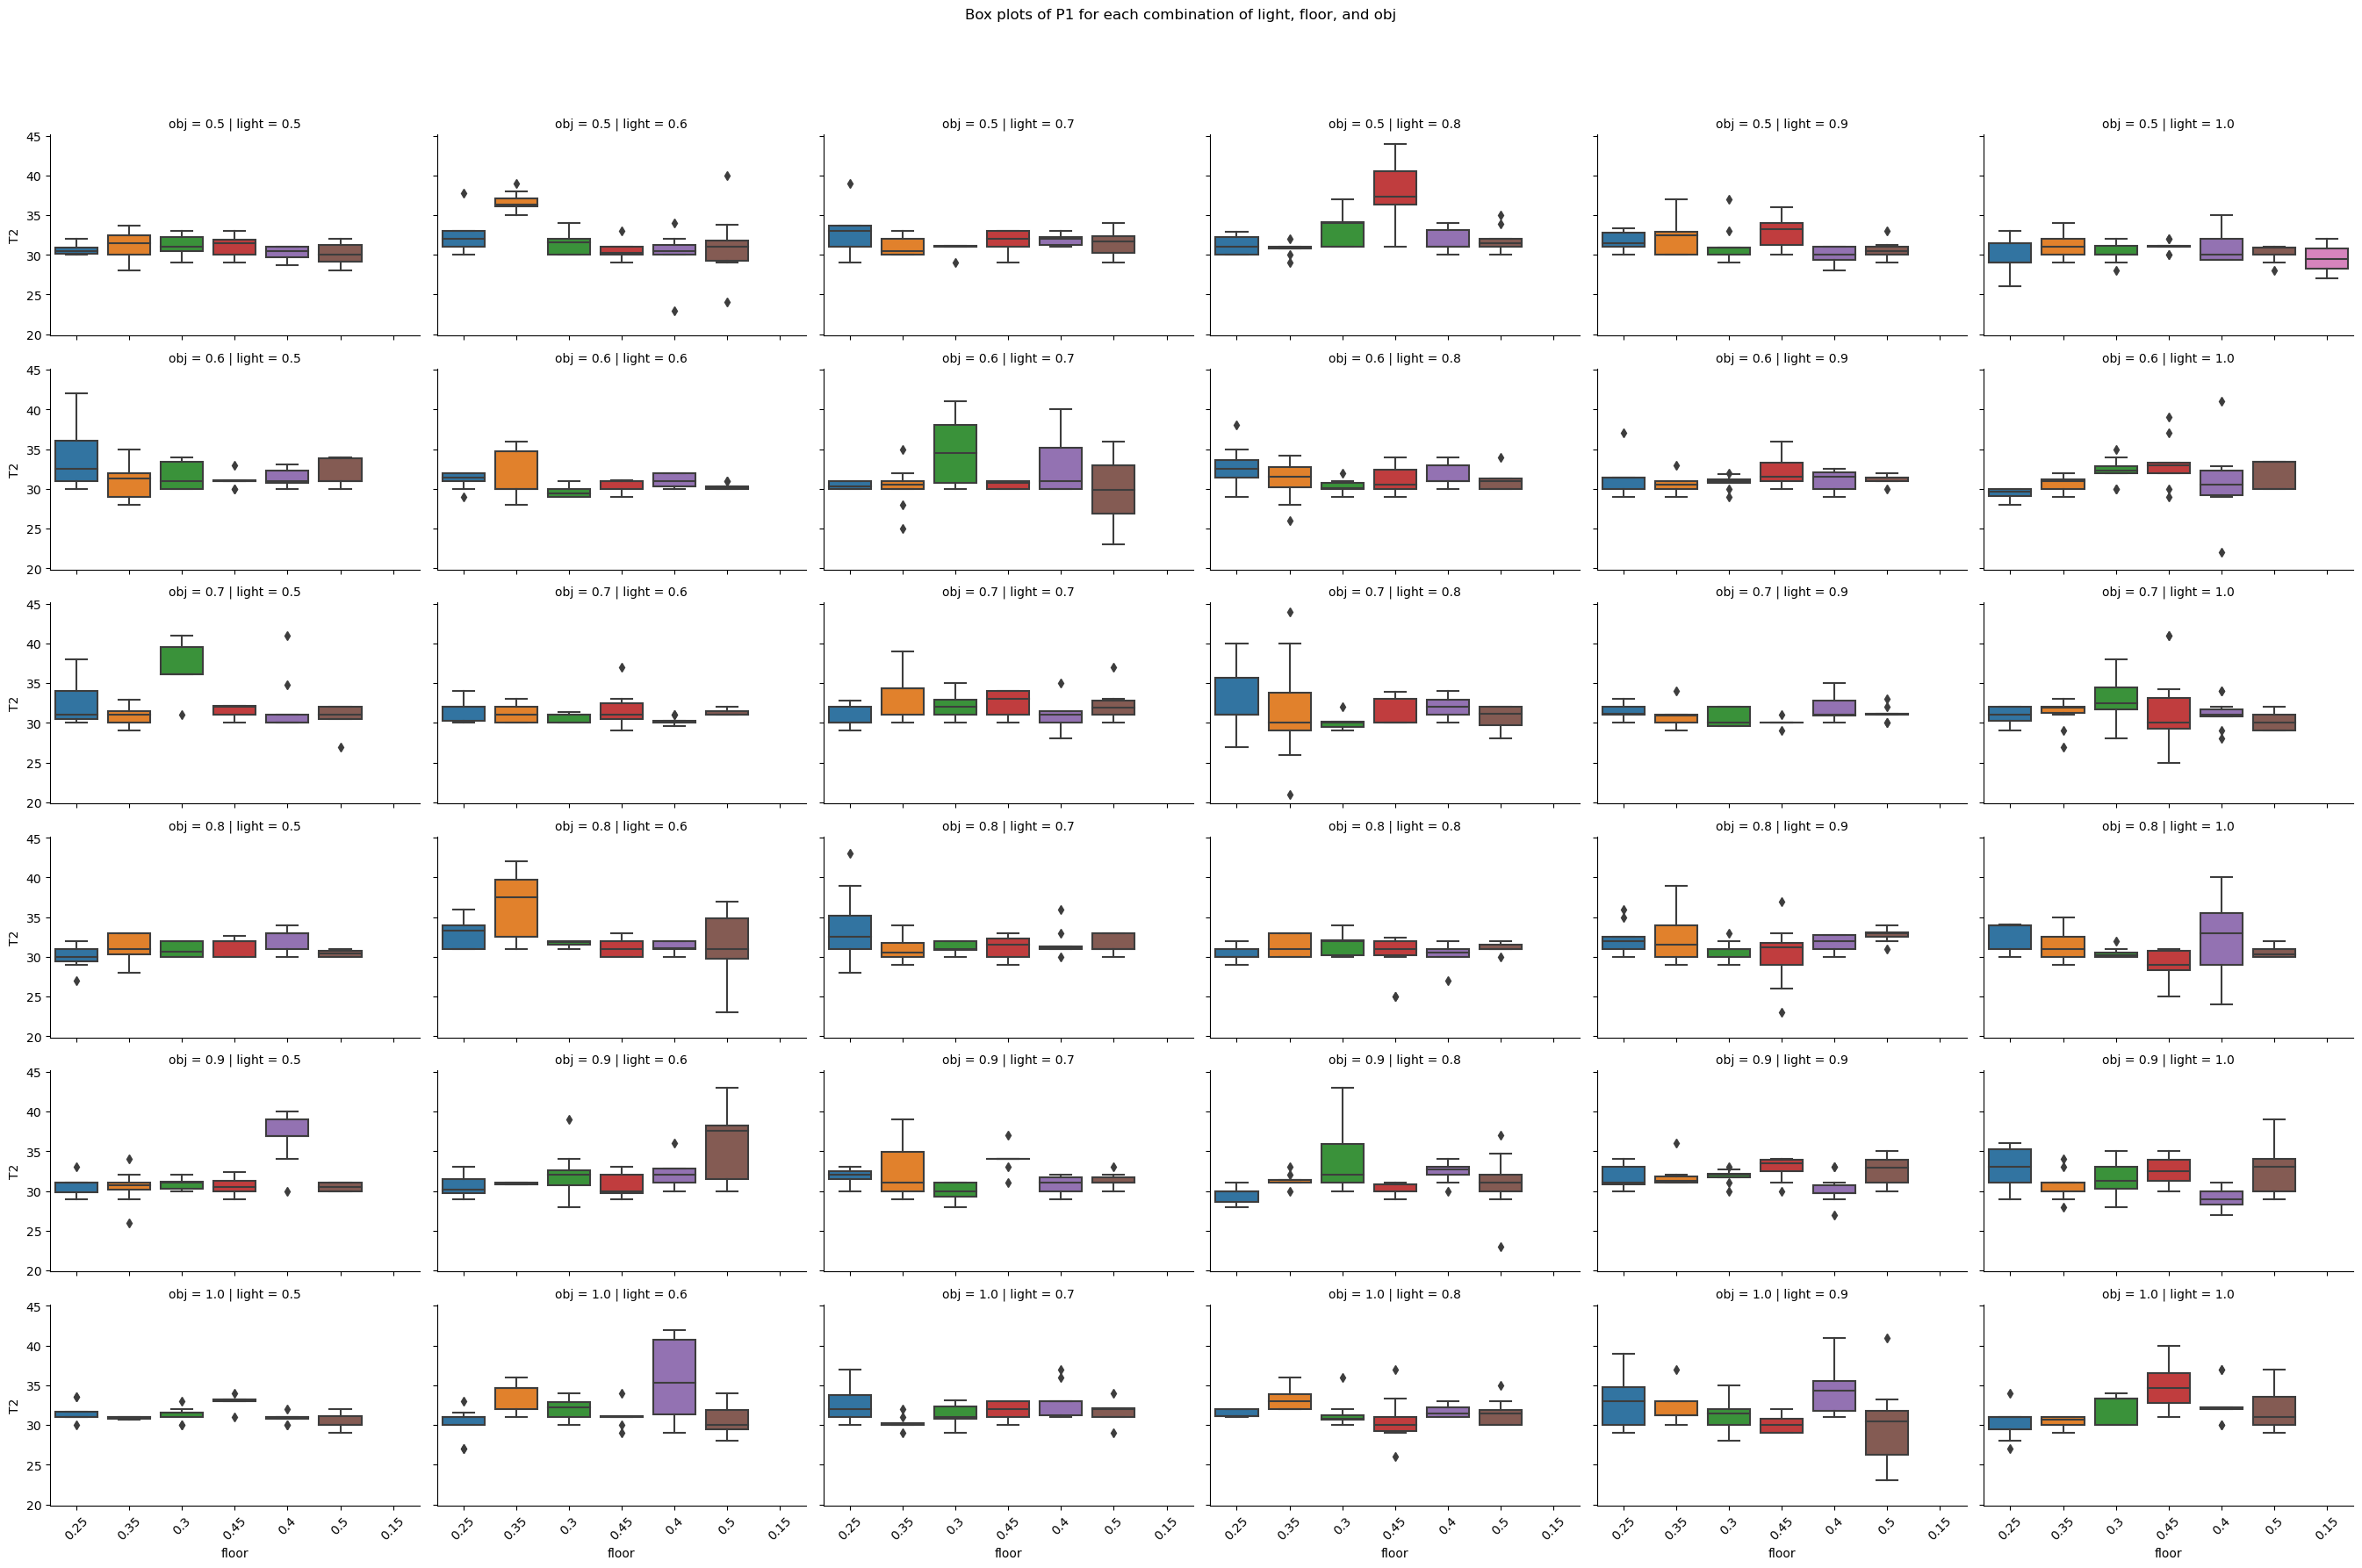

In [10]:
def main():
    
    csv_folder = "Data/Lookup tables/Raw data/csv_files" # raw data
    #hist_file = "Data/Historical logs/day.csv"           # one day run
    
    #----Smooth data
    # Uses Winsorize algorithm.
    # Outliers are considered to be outside n standard dev.
    # Replacement of outliers is done using the values of +-n standard dev.
    #If n<0,
    # Outliers are considered to be outside |n| standard dev.
    # Replacement of outliers with the mean.
    std = -1
    smoothRawData(csv_folder,"T2,T2F,TR,T3",std,"false")        # T1 and T1F not considered anymore
    
    #Compare plotting data
    checkFor = "T2"
    # - raw data
    csv_name = "outcome"
    df = combineM1M2M3(csv_folder,csv_name)
    plotFacetGridBox(df,checkFor)
    
    # - smoothed
    csv_name = "smoothoutcome"
    dfsmooth = combineM1M2M3(csv_folder,csv_name)
    plotFacetGridBox(dfsmooth,checkFor)
    
    
if __name__ == "__main__":
    main()
    
    

#### Notice that there still variability in the values of T2. For a combination of M1,M2,M3 (i.e., light, floor, obj), the ideal is to have a single value, so that we assume that knowing M1,M2,M3 will always translate into a deterministic value of T2.

#### We make the assumption that this is the case: "The values of all times, Ti's, are fixed for any M1,M2,M3"

# Read p1,p2,...,T1,T2,... for each combinations of M1-M3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
#Previously in C code
def get_line(line):
    return line

def get_val(sum_val, count):
    return sum_val / count if count != 0 else -1

def print_val(val, label):
    if val > -1:
        print(f"{label}: {val}")
    else:
        print(f"{label}: No recorded data.")

def print_val_to_file(output_file, val):
    if val > -1:
        output_file.write(f"{val:.2f},")
    else:
        output_file.write(f"NoData,")

def print_enter_to_file(output_file):
    output_file.write("\n")

def print_val_to_filename(output_file, filename):
    output_file.write(f"file:{filename},,")




def get_field(ttype,line,num):
    if(ttype==int):
        return int(float(line[num-1]))
    if ttype==float:
        return float(line[num-1])

def get_data(filename,outputFile):
    # Running totals and counts
    p1_count = p1_sum = T1_count = T1_sum = T1F_count = T1F_sum = 0
    p2_sum = p3_sum = grab_attempts = T2_count = T2_sum = TR_count = TR_sum = T2F_count = T2F_sum = 0
    p4_count = p4_sum = T3_count = T3_sum = 0

    with open(filename, 'r') as stream:
        stream.readline()  # Discard first line that contains field names
        for line in stream:
            
            line = line.strip().split(',')
            
            p1_check = get_field(int,line,5)
            p1_count += 1
            if p1_check == 1:
                p1_sum += 1
                T1_count += 1
                T1_sum += get_field(float,line,6)
                p2_check = get_field(int,line,8)
                if p2_check == 1:
                    p2_sum += 1
                    grab_attempts += 1
                    T2_count += 1
                    T2_sum += get_field(float,line,9)
                    p4_count += 1
                    if get_field(int,line,50) == 1:
                        p4_sum += 1
                    T3_count += 1
                    T3_sum += get_field(float,line,51)
                elif get_field(int,line,9) > -1:
                    grab_attempts += 1
                    T2_count += 1
                    T2_sum += get_field(float,line,10)
                for i in range(10, 29):
                    if get_field(int,line,i) > -1:
                        p3_sum += 1
                        grab_attempts += 1
                        T2F_count += 1
                        T2F_sum += get_field(float,line,i)
                    else:
                        break
                for i in range(30, 49):
                    if get_field(int,line,i) > -1:
                        TR_count += 1
                        TR_sum += get_field(float,line,i)
                    else:
                        break
            else:
                T1F_count += 1
                T1F_sum += get_field(float,line,7)

    # Calculate values
    p1 = get_val(p1_sum, p1_count)
    T1 = get_val(T1_sum, T1_count)
    T1F = get_val(T1F_sum, T1F_count)
    p2 = get_val(p2_sum, grab_attempts)
    p3 = get_val(p3_sum, grab_attempts)
    T2 = get_val(T2_sum, T2_count)
    TR = get_val(TR_sum, TR_count)
    T2F = get_val(T2F_sum, T2F_count)
    p4 = get_val(p4_sum, p4_count)
    T3 = get_val(T3_sum, T3_count)

    # Print to terminal
    #print(f"Fileeeee: {filename}")
    expected_path = "Data/Lookup tables/Raw data/csv_files/outcome_0.5_0.25_0.5.csv"
    if filename == expected_path:
        print("Paths match!")
        print_val(p1, "p1")
        print_val(T1, "T1")
        print_val(T1F, "T1F")
        print_val(p2, "p2")
        print_val(p3, "p3")
        print_val(T2, "T2")
        print_val(TR, "TR")
        print_val(T2F, "T2F")
        print_val(p4, "p4")
        print_val(T3, "T3")
        
    
    m = filename.split("outcome")[1].replace(".csv","").split("_")
    m1=float(m[1]); m2=float(m[2]);  m3=float(m[3])
    # Write to output file
    with open(outputFile, "a") as output_file:
        #print_val_to_filename(output_file, filename)
        print_val_to_file(output_file, m1)
        print_val_to_file(output_file, m2)
        print_val_to_file(output_file, m3)
        print_val_to_file(output_file, p1)
        print_val_to_file(output_file, T1)
        print_val_to_file(output_file, T1F)
        print_val_to_file(output_file, p2)
        print_val_to_file(output_file, p3)
        print_val_to_file(output_file, T2)
        print_val_to_file(output_file, TR)
        print_val_to_file(output_file, T2F)
        print_val_to_file(output_file, p4)
        print_val_to_file(output_file, T3)
        print_enter_to_file(output_file)
        
def readRawData(folder_path,outputFile,start="smoothoutcome"):
    clean_file(outputFile)
    with open(outputFile, "a") as output_file:
        col = ", ".join(["M1","M2","M3","p1","T1","T1F","p2","p3","T2","TR","T2F","p4","T3","Pretry","violation"])+"\n"
        output_file.write(col)
    for filename in os.listdir(folder_path):
        full_path = get_full_path(folder_path, filename)
        if os.path.isfile(full_path) and (filename.split("_")[0]==start):
            #print(f"File: {filename}")
            get_data(full_path,outputFile)
    print("Saved in ",outputFile)

In [ ]:
def main():
    csv_folder = "Data/Lookup tables/Raw data/csv_files" # raw data
    hist_file = "Data/Historical logs/day.csv"           # one day run
    
    #Read raw data and obtain p1,p2,p3...,T1,T2,... from M1-M3 from saved simulations
    startwith="smoothoutcome" # or "outcome" for unfiltered
    readRawData(csv_folder,"output.csv",startwith)

if __name__ == "__main__":
    main()


## Violation zone - Using Julie's fitted funtions

For reference, to obtain bounds of requirements,
```
R1 is very sentitive after 0.57
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.075# 0% violated
R1_bound = 0.58; R2_bound = 232; R3_bound = 0.075# 12.5 violated <-----
R1_bound = 0.59; R2_bound = 232; R3_bound = 0.075# 52.25 violated R1

R2 sensitive around 190-200
R1_bound = 0.57; R2_bound = 190; R3_bound = 0.075# 79.53% violated
R1_bound = 0.57; R2_bound = 200; R3_bound = 0.075# 22.46 violated <-----

R3 not very sensitive
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.1  # 0% violated
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.05 # 11% violated <-----
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.045# 20 violated 
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.04 # 25 violated
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.02 # 50 violated
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.001# 80 violated

R1_bound = 0.58; R2_bound = 200; R3_bound = 0.045# 45.18% violated
R1_bound = 0.58; R2_bound = 200; R3_bound = 0.05 # 40.625% violated <----- This was selected
```

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [12]:
# Req. bounds
R1_bound = 0.58; R2_bound = 200; R3_bound = 0.05 # 40.625% violated

#Light value
minM1=0.5; maxM1= 1; M =20
#Floor friction
minM2=0.25; maxM2=0.5; N=20
#Object friction
minM3=0.5; maxM3=1; L=20

#fun
p1 =lambda M1   : M1*0.0381941 + 0.962500
p2 = lambda M1,M3: 0.65301 + 0.05833 * M1 - 0.11750 * M3 - 0.04865 * M1 * M3       # before only M3
p3 = lambda M1,M3: 0.16218 - 0.04194 * M1 - 0.01444 * M3 - 0.04167 * M1 * M3       # before only M1
p4 = lambda M3   : 0.80629 + 0.21175 * M3
pR = lambda x : 0.6
T1 = lambda M1,M2: 134.171 - 11.929 * M1 - 7.999 * M2     
T2 = lambda M3 : 25.3942 - 5.0085 * M3
T3 = lambda M2: 53.7                          
T1F= lambda M2: 349.772 - 10.97 * M2                                               # fixed before
T2F= lambda x :59.1 
TR = lambda M1,M3: 52.8953 - (0.2339 *M1) + (8.5904 *M3) + (15.6654 * M1 * M3)     # before M


fileDay = "./Data/Day/Historical logs/day_faulty_light.csv"#day_faulty_light_degrading_grip.csv, day_degrading_grip.csv

In [ ]:
csv_folder = "Data/Lookup tables/Raw data/csv_files" # raw data
    hist_file = "Data/Historical logs/day_faulty_light.csv"           # one day run
    
    #----Smooth data
    # Uses Winsorize algorithm.
    # Outliers are considered to be outside n standard dev.
    # Replacement of outliers is done using the values of +-n standard dev.
    #If n<0,
    # Outliers are considered to be outside |n| standard dev.
    # Replacement of outliers with the mean.
    std = -1
    smoothRawData(csv_folder,
                  
                  
def main():
    hist_file = "Data/Historical logs/day.csv"           # one day run
    
    #Read raw data and obtain p1,p2,p3...,T1,T2,... from M1-M3 from saved simulations
    startwith="smoothoutcome" # or "outcome" for unfiltered
    readRawData(csv_folder,"output.csv",startwith)

if __name__ == "__main__":
    main()



In [26]:
hist_file = "Data/Historical logs/day_faulty_light.csv"           # one day run
df_light = pd.read_csv(hist_file)
df_light.columns=["Time","M1","M2","M3","state"]
df_light.head()




,Time,M1,M2,M3,state
0,0,0.962056,0.433821,0.953896,0
1,5,0.962056,0.433821,0.953896,0
2,10,0.962056,0.433821,0.953896,0
3,15,0.962056,0.433821,0.953896,0
4,20,0.962056,0.433821,0.953896,0


In [ ]:
inf = float('inf')

N = 10 # update threshold: capacity of buffer (initially empty) used to store the last N observations - triggers an update of the linear regression model 
t = 10 # prediction window within which any disruptions are to be predicted
violationTime = [inf,inf,inf]

violationTime

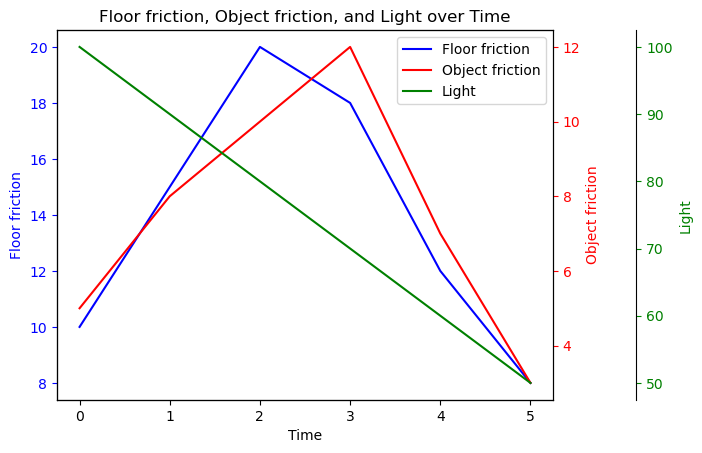

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your actual DataFrame)
data = {
    "Time": [0, 1, 2, 3, 4, 5],
    "Floor friction": [10, 15, 20, 18, 12, 8],
    "Object friction": [5, 8, 10, 12, 7, 3],
    "Light": [100, 90, 80, 70, 60, 50]
}
df = pd.DataFrame(data)

# Plotting
fig, ax1 = plt.subplots()

# Plotting y1 (Floor friction)
ax1.plot(df["Time"], df["Floor friction"], color='b', label='Floor friction')
ax1.set_xlabel('Time')
ax1.set_ylabel('Floor friction', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(df["Time"], df["Object friction"], color='r', label='Object friction')
ax2.set_ylabel('Object friction', color='r')
ax2.tick_params('y', colors='r')

# Creating a third y-axis sharing the same x-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Adjust the position of the third y-axis
ax3.plot(df["Time"], df["Light"], color='g', label='Light')
ax3.set_ylabel('Light', color='g')
ax3.tick_params('y', colors='g')

# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right')

plt.title('Floor friction, Object friction, and Light over Time')

plt.show()


In [ ]:
#Read day data
def create_EnvSys_df():
    col = ["M1","M2","M3","p1","p2","p3","p4","T1","T1F","T2","T2F","TR","T3","Pretry","violation"]
    df = pd.DataFrame(columns=col)
    M1 = []; M2 = []; M3 = []
    for m1, m2, m3 in [(m1,m2,m3) for m1 in np.linspace(minM1, maxM1, M) for m2 in np.linspace(minM2, maxM2, N) for m3 in np.linspace(minM3, maxM3, L)]:#create all combinations of env. values
        M1.append(m1); M2.append(m2); M3.append(m3)                
    df['M1']=M1; df['M2']=M2; df['M3']=M3
    return df
    


In [ ]:
def checkViolation(p1,p2,p3,p4,T1,T1F,T2,T2F,TR,T3,Pretry):
    violation = 0
    r1,r2,r3 =0,0,0
    
    # compute R1-R3
    R1= (p1*p2*p4)/(1-Pretry*p3)
    R2= (p1*(p3*T2-p2*T3-p3*T2F-T1-T2+T1F)+Pretry*p3*(T1F-p1*TR-p1*T1F)-T1F) / (Pretry*p3-1)
    R3 = (p1*p2*(1-p4))/(1-Pretry*p3)
    # check violation   (i.e., does not comply with innequalities, hence innequality symbols are flipped)
    if R1 <= R1_bound:
        violation = 1; r1=1
    if R2 >= R2_bound:
        violation = 1; r2=1
    if R3 >= R3_bound:
        violation = 1; r3=1
    return [R1,R2,R3,r1,r2,r3,violation]

def addViolationsDF(df):
    for index,row in df.iterrows():
        M1 = row['M1']; M2= row['M2']; M3 = row['M3']
        x = row['M3'] #dummy
        #check violation
        [R1,R2,R3,r1,r2,r3,violation] = checkViolation(p1(M1),p2(M1,M3),p3(M1,M3),p4(M3),T1(M1,M2),
                                                       T1F(M2),T2(x),T2F(x),TR(M1,M3),T3(M2),pR(x))
        df.loc[index,'p1'],df.loc[index,'p2'], df.loc[index,'p3'],df.loc[index,'p4'], df.loc[index,'T1'],df.loc[index,'T1F'],df.loc[index,'T2'],df.loc[index,'T2F'],df.loc[index,'TR'],df.loc[index,'T3'], df.loc[index,'Pretry']=p1(M1),p2(M1,M3),p3(M1,M3),p4(M3),T1(M1,M2), T1F(M2),T2(x),T2F(x),TR(M1,M3),T3(M2),pR(x)
        df.loc[index,'R1'],df.loc[index,'R2'],df.loc[index,'R3'] = R1,R2,R3
        df.loc[index,'r1'],df.loc[index,'r2'],df.loc[index,'r3'] = r1,r2,r3
        df.loc[index,'violation'] = violation
    
    return df

def plotViolationZone():
    #a) set ranges (e.g., light cannot be >1 or <0)
    light_range_values = [minM1,maxM1] #min,max
    floor_range_values = [minM2,maxM2] #min,max
    object_range_values = [minM3,maxM3] #min,max

    # Plot the scatter plot
    fig = px.scatter_3d(df, x='M1', y='M2', z='M3', color=df['violation'])
    fig.update_layout(title_text='Violation (1) and safe (0) zone')
    fig.update_scenes(xaxis_range=light_range_values,
                      yaxis_range=floor_range_values,
                      zaxis_range=object_range_values)
    fig.show()

In [ ]:

df = create_EnvSys_df()
df = addViolationsDF(df)

# Sum the values in the 'Age' column
total_violation = df['violation'].sum()
total = len(df['violation'])

print(" Total data points: {}.\n Total data points in violation: {}.\n Percentage in violation: {}."
      .format(total,total_violation,total_violation/total*100))

output = 'lookUpTableViolation.xlsx'
clean_file(output)
df.to_excel(output, index=False)

plotViolationZone()
df.head(5)


# 2 Get time to boundary

#### 1 Read last N data measurements M1-M3 of robot performance (in a day of work)
#### 2 Stimate past from this data
#### 3 Calculate time to boundary
#### 4 Calculate "real time to boundary" (aka, read future M1-M3 and see if enter violation)
**Check also if out of operational domain**